In [4]:
import openmc
import os
import numpy as np
import neutronics_material_maker as nmm

# Define materials
# Tumor Material
tumor_material = openmc.Material()
tumor_material.add_nuclide('H1', 0.106)
tumor_material.add_nuclide('B10', 19.3e-4)
tumor_material.add_nuclide('B11', 85.3e-4)
tumor_material.add_nuclide('C12', 0.14)
tumor_material.add_nuclide('N14', 0.0184)
tumor_material.add_nuclide('O16', 0.726)
tumor_material.add_nuclide('Na22', 0.0014)
tumor_material.add_nuclide('P31', 0.0039)
tumor_material.add_element('Cl', 0.0014)
tumor_material.add_element('K', 0.0039)
tumor_material.set_density('g/cm3',1.0039)

# Regular Skin Material
skin_material = nmm.Material.from_library(name='Skin (ICRP)', material_id=1)
skin_material = skin_material.openmc_material


# Define materials collection and export to XML
my_materials = openmc.Materials([tumor_material, skin_material])
my_materials.export_to_xml()

# Set cross sections path
os.environ['OPENMC_CROSS_SECTIONS'] = "/Volumes/Untitled/cross_test/endfb-viii.0-hdf5/cross_sections.xml"


# Change Tumor Radius, Change Neutron Source Energy, Change B-10 Concentration
# Define radii in cm
# CHANGE HERE
inner_radius = 0.4
middle_radius = 0.5

# Transmission boundary (default) allows neutrons to cross
inner_cylinder = openmc.ZCylinder(r=inner_radius, boundary_type='transmission')
middle_cylinder = openmc.ZCylinder(r=middle_radius, boundary_type='vacuum')
top_plane = openmc.ZPlane(z0=10.0, boundary_type='vacuum') #10 cm high
bottom_plane = openmc.ZPlane(z0=-10.0, boundary_type='vacuum')

# Define cells
inner_slab = openmc.Cell(region=-inner_cylinder, fill=skin_material)
middle_slab = openmc.Cell(region=+inner_cylinder & -middle_cylinder, fill=tumor_material)

# Define geometry
geometry = openmc.Geometry([inner_slab, middle_slab])
geometry.export_to_xml()

# Define source
point = openmc.stats.Point((0, 0, 0))

energy_distribution = openmc.stats.PowerLaw(1, 1000, -1.001)
source = openmc.Source(space=point, energy=energy_distribution)

# Define settings
settings = openmc.Settings()
settings.batches = 10
settings.inactive = 0
settings.particles = 10000
settings.run_mode = 'fixed source'
settings.source = source

# https://www.w3resource.com/numpy/array-creation/logspace.php
# neutrons from 10^-5 to 10^10 eV with 50 equally space bins
energy_bins = np.logspace(-5, 4, 50)

# Define filters
neutron_particle_filter = openmc.ParticleFilter(['neutron'])
inner_slab_filter = openmc.CellFilter(inner_slab)
middle_slab_filter = openmc.CellFilter(middle_slab)

# Define Dose Coefficients
energy_bins_n, dose_coeffs_n = openmc.data.dose_coefficients(particle="neutron", geometry="AP")
energy_function_filter_n = openmc.EnergyFunctionFilter(energy_bins_n, dose_coeffs_n)
energy_function_filter_n.interpolation = "cubic"  # cubic interpolation is recommended by ICRP

# Define tallies
# Calculate dose using dose coefficients
inner_flux = openmc.Tally(name="inner_flux")
inner_flux.filters = [inner_slab_filter, neutron_particle_filter]
inner_flux.scores=["flux"]

middle_flux = openmc.Tally(name="middle_flux")
middle_flux.filters = [middle_slab_filter, neutron_particle_filter]
middle_flux.scores=["flux"]

tumor_na = openmc.Tally(name="tumor_na")
tumor_na.filters = [middle_slab_filter, neutron_particle_filter, energy_function_filter_n, 
                    openmc.EnergyFilter(energy_bins)]
tumor_na.scores = ["(n,a)"]

tumor_ga = openmc.Tally(name="tumor_ga")
tumor_ga.filters = [middle_slab_filter, neutron_particle_filter, energy_function_filter_n, 
                    openmc.EnergyFilter(energy_bins)]
tumor_ga.scores = ["(n,gamma)"]

check_tumor_ga = openmc.Tally(name="check_tumor_ga")
check_tumor_ga.filters = [middle_slab_filter, neutron_particle_filter, energy_function_filter_n]
check_tumor_ga.scores = ["(n,gamma)"]

tumor_np = openmc.Tally(name="tumor_np")
tumor_np.filters = [middle_slab_filter, neutron_particle_filter, energy_function_filter_n, 
                             openmc.EnergyFilter(energy_bins)]
tumor_np.scores = ["(n,p)"]

skin_na = openmc.Tally(name="skin_na")
skin_na.filters = [inner_slab_filter, neutron_particle_filter, energy_function_filter_n,
                   openmc.EnergyFilter(energy_bins)]
skin_na.scores = ["(n,a)"]

skin_ga = openmc.Tally(name="skin_ga")
skin_ga.filters = [inner_slab_filter, neutron_particle_filter, energy_function_filter_n,
                   openmc.EnergyFilter(energy_bins)]
skin_ga.scores = ["(n,gamma)"]


skin_np = openmc.Tally(name="skin_np")
skin_np.filters = [inner_slab_filter, neutron_particle_filter, energy_function_filter_n,
                   openmc.EnergyFilter(energy_bins)]
skin_np.scores = ["(n,p)"]


my_tallies = openmc.Tallies([inner_flux,middle_flux,tumor_na,tumor_np,tumor_ga,skin_na,skin_np,
                             skin_ga,check_tumor_ga])
settings.tallies = my_tallies

# Create the model and run simulation
model = openmc.model.Model(geometry, my_materials, settings, my_tallies)
openmc_exec = '/Users/arifv/opt/anaconda3/envs/new_env/bin/openmc'
!rm *.h5
model.run(openmc_exec=openmc_exec)


statepoint = openmc.StatePoint('statepoint.10.h5')

inner_flux = statepoint.tallies[inner_flux.id].mean
middle_flux = statepoint.tallies[middle_flux.id].mean
print("Inner Flux After .mean method:",inner_flux)
print("Middle Flux After .mean method:", middle_flux)

# Define RBE values for various interactions
tumor_doseDict = {1: {'name': 'tumor_na', 'conversion': 20,'RBE':3.8}, #n,a
            2: {'name': 'tumor_ga', 'conversion': 1, 'RBE':1},   #n,gamma
            3: {'name': 'tumor_np', 'conversion': 1, 'RBE': 3.2}    #n,p
           }

skin_doseDict = {1: {'name': 'skin_na', 'conversion': 20,'RBE':1.3}, #n,a
                2: {'name': 'skin_ga', 'conversion': 1, 'RBE':1},   #n,gamma
                3: {'name': 'skin_np', 'conversion': 1, 'RBE': 3.2}    #n,p
               }

D_TOT = 0
reg_D_TOT = 0
neutrons_per_second = 1e12 # Subject to change


tumor_na_results = statepoint.get_tally(name='tumor_na').mean.flatten()
tumor_ga_results = statepoint.get_tally(name='tumor_ga').mean.flatten()
tumor_np_results = statepoint.get_tally(name='tumor_np').mean.flatten()

skin_na_results = statepoint.get_tally(name='skin_na').mean.flatten()
skin_ga_results = statepoint.get_tally(name='skin_ga').mean.flatten()
skin_np_results = statepoint.get_tally(name='skin_np').mean.flatten()


tumor_dose = 0
skin_dose = 0

values = []

# π * (r_1^2 - r_0^2) * h
middle_slab_volume_cm3 = np.pi*(middle_radius**2 - inner_radius**2)*20
inner_slab_volume_cm3 = np.pi*(inner_radius**2)*20

for i in range (1,4):
    for j, tally_result in enumerate(statepoint.get_tally(name=tumor_doseDict[i]['name']).mean.flatten()):
        tally_result = tally_result * middle_flux.flatten() * neutrons_per_second
        tally_result = tally_result/middle_slab_volume_cm3
        tally_dose_pSv = tally_result * 60 * 60
        tally_dose_Sv = tally_dose_pSv * (1e-12)
        tally_dose_Gy = tally_dose_Sv/tumor_doseDict[i]['conversion']
        tumor_dose= tumor_dose + tally_dose_Gy * tumor_doseDict[i]['RBE']
    print(i,"th",tumor_dose)
    values.append(tumor_dose)
for i in range (1,4):
    for j, tally_result in enumerate(statepoint.get_tally(name=skin_doseDict[i]['name']).mean.flatten()):
        tally_result = tally_result * inner_flux.flatten() * neutrons_per_second
        tally_result = tally_result/inner_slab_volume_cm3
        tally_dose_pSv = tally_result * 60 * 60
        tally_dose_Sv = tally_dose_pSv * (1e-12)
        tally_dose_Gy = tally_dose_Sv/skin_doseDict[i]['conversion']
        skin_dose = skin_dose + tally_dose_Gy * skin_doseDict[i]['RBE']
    print(i,"th",skin_dose)
    values.append(skin_dose)
print ("DTOT/hr:", tumor_dose)
print ("reg_DTOT/hr:", skin_dose)

/Users/arifv/opt/anaconda3/envs/new_env/lib/python3.8/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/Users/arifv/opt/anaconda3/envs/new_env/lib/python3.8/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=35.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [5]:
tumor_values = values[:3]
skin_values = values[3:]
print("(n,a) tumor dose =",tumor_values[0])
print("(n,gamma) tumor dose =",tumor_values[1]-tumor_values[0])
print("(n,p) tumor dose =",tumor_values[2]-tumor_values[1])

print("(n,a) skin dose =",skin_values[0])
print("(n,gamma) skin dose =",skin_values[1]-skin_values[0])
print("(n,p) skin dose =",skin_values[2]-skin_values[1])

print("(n,a) cancer/skin ratio =", tumor_values[0]/skin_values[0])
print("(n,gamma) cancer/skin ratio =", ((tumor_values[1]-tumor_values[0]))/(skin_values[1]-skin_values[0]))
print("(n,p) cancer/skin ratio =", ((tumor_values[2]-tumor_values[1])/(skin_values[2]-skin_values[1])))
print("total ratio =",tumor_dose/skin_dose)

(n,a) tumor dose = [0.25321152]
(n,gamma) tumor dose = [0.08562045]
(n,p) tumor dose = [25.37308662]
(n,a) skin dose = [1.67444189e-05]
(n,gamma) skin dose = [1.10918314]
(n,p) skin dose = [0.59985668]
(n,a) cancer/skin ratio = [15122.14422471]
(n,gamma) cancer/skin ratio = [0.07719234]
(n,p) cancer/skin ratio = [42.29858133]
total ratio = [15.04450997]


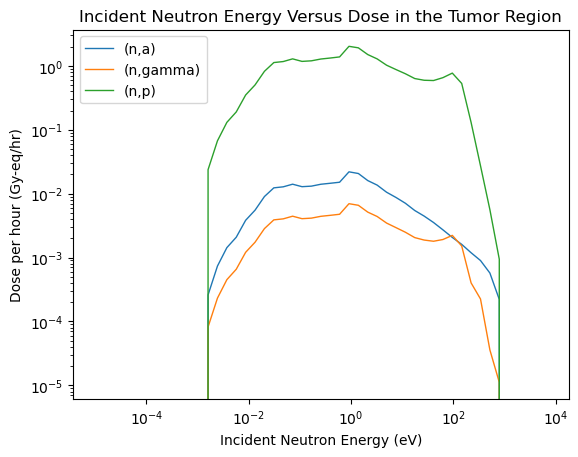

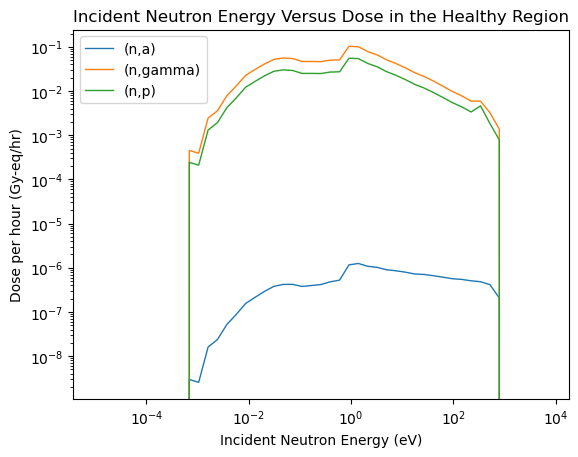

/var/folders/cl/x3pr68j11831lpvys_x6f8mr0000gn/T/ipykernel_65122/1613072032.py:39: RuntimeWarning: invalid value encountered in divide
  tumor_divided_skin_na = tumor_na_results_converted/skin_na_results_converted
/var/folders/cl/x3pr68j11831lpvys_x6f8mr0000gn/T/ipykernel_65122/1613072032.py:40: RuntimeWarning: invalid value encountered in divide
  tumor_divided_skin_ga = tumor_ga_results_converted/skin_ga_results_converted
/var/folders/cl/x3pr68j11831lpvys_x6f8mr0000gn/T/ipykernel_65122/1613072032.py:41: RuntimeWarning: invalid value encountered in divide
  tumor_divided_skin_np = tumor_np_results_converted/skin_np_results_converted


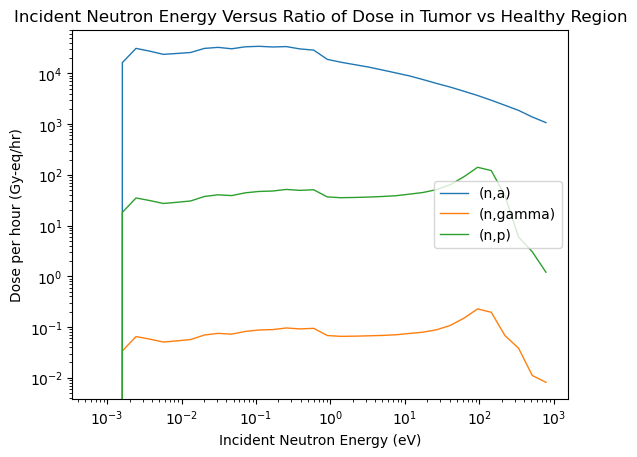

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


tumor_na_results_converted = tumor_na_results * middle_flux.flatten() * neutrons_per_second * 3600 * 3.8 * (1e-12)/(middle_slab_volume_cm3  * 20)
tumor_ga_results_converted = tumor_ga_results * middle_flux.flatten() * neutrons_per_second * 3600 * 1.0 * (1e-12)/(middle_slab_volume_cm3)
tumor_np_results_converted = tumor_np_results * middle_flux.flatten() * neutrons_per_second * 3600 * 3.2 * (1e-12)/(middle_slab_volume_cm3)

skin_na_results_converted = skin_na_results * inner_flux.flatten() * neutrons_per_second * 3600 * 1.3 * (1e-12)/(inner_slab_volume_cm3  * 20)
skin_ga_results_converted = skin_ga_results * inner_flux.flatten() * neutrons_per_second * 3600 * 1.0 * (1e-12)/(inner_slab_volume_cm3)
skin_np_results_converted = skin_np_results * inner_flux.flatten() * neutrons_per_second * 3600 * 3.2 * (1e-12)/(inner_slab_volume_cm3)

energy_bins_cutoff = energy_bins[:49]

plt.figure()
plt.loglog(energy_bins_cutoff, tumor_na_results_converted, linewidth=1, linestyle="-", label="(n,a)")
plt.loglog(energy_bins_cutoff, tumor_ga_results_converted, linewidth=1, linestyle="-", label="(n,gamma)")
plt.loglog(energy_bins_cutoff, tumor_np_results_converted, linewidth=1, linestyle="-", label="(n,p)")
plt.xlabel("Incident Neutron Energy (eV)")
plt.ylabel("Dose per hour (Gy-eq/hr)")
plt.title('Incident Neutron Energy Versus Dose in the Tumor Region')
plt.legend()
plt.savefig('tumor_dose_all_01.png')
plt.show()

plt.figure()
plt.loglog(energy_bins_cutoff, skin_na_results_converted, linewidth=1, linestyle="-", label="(n,a)")
plt.loglog(energy_bins_cutoff, skin_ga_results_converted, linewidth=1, linestyle="-", label="(n,gamma)")
plt.loglog(energy_bins_cutoff, skin_np_results_converted, linewidth=1, linestyle="-", label="(n,p)")
plt.xlabel("Incident Neutron Energy (eV)")
plt.ylabel("Dose per hour (Gy-eq/hr)")
plt.title('Incident Neutron Energy Versus Dose in the Healthy Region')
plt.legend()
plt.savefig('skin_dose_all_01.png')
plt.show()


tumor_divided_skin_na = tumor_na_results_converted/skin_na_results_converted
tumor_divided_skin_ga = tumor_ga_results_converted/skin_ga_results_converted
tumor_divided_skin_np = tumor_np_results_converted/skin_np_results_converted

plt.figure()
plt.loglog(energy_bins_cutoff, tumor_divided_skin_na, linewidth=1, linestyle="-", label="(n,a)")
plt.loglog(energy_bins_cutoff, tumor_divided_skin_ga, linewidth=1, linestyle="-", label="(n,gamma)")
plt.loglog(energy_bins_cutoff, tumor_divided_skin_np, linewidth=1, linestyle="-", label="(n,p)")
plt.xlabel("Incident Neutron Energy (eV)")
plt.ylabel("Dose per hour (Gy-eq/hr)")
plt.title("Incident Neutron Energy Versus Ratio of Dose in Tumor vs Healthy Region")
plt.savefig('dose_ratio_all_01.png')
plt.legend()
plt.show()

[5.654866776461626, 6.936636579126263, 8.268671864248335, 9.650972631827845, 11.083538881864786, 12.56637061435917, 14.09946782931099, 15.682830526720245, 17.316458706586943, 19.000352368911074, 20.734511513692627]
[0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7]


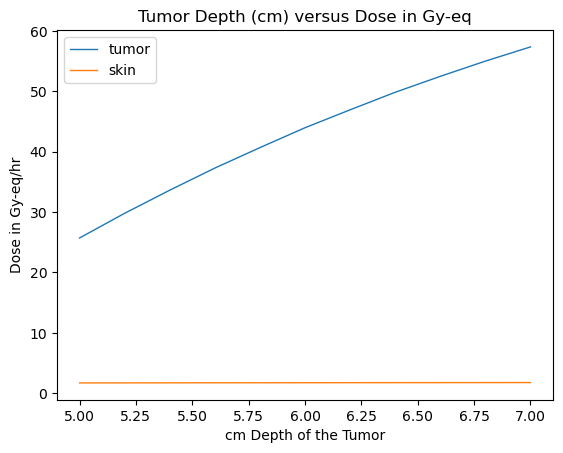

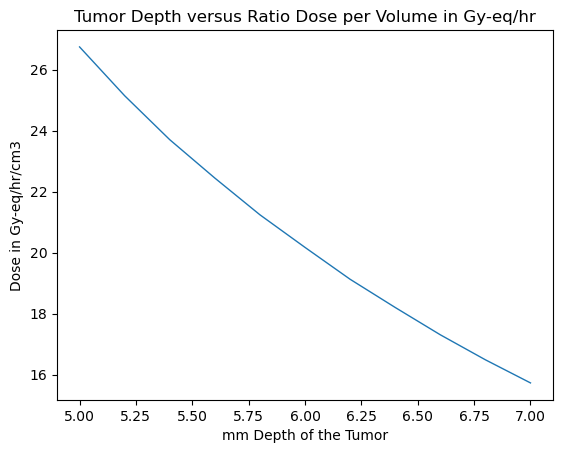

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

tumor_cm = [0.5,0.52, 0.54, 0.56, 0.58, 
            0.6, 0.62, 0.64, 0.66, 0.68,
            0.7]
tumor_mm = []
for i in range(0,len(tumor_cm)):
    tumor_mm.append(tumor_cm[i]*10)
    
tumor_volumes_cm2 = []
for i in range (0,len(tumor_cm)):
    tumor_cm2 = tumor_cm[i]**2
    tumor_volumes_cm2.append(np.pi * (tumor_cm2 - 0.4**2) * 20)

print(tumor_volumes_cm2)
print(tumor_cm)


tumor_cm_dose = [25.71191858, 29.79938952, 33.62442096, 37.2859284, 40.67104019, 
                 43.96398264, 46.93082888, 49.8357923, 52.47455586, 54.99598431,
                 57.34429253
                ]

tumor_cm_dose_cm3 = []
skin_cm_dose_cm3 = []
ratio_cm_dose_cm3 = []

tumor_mm_dose_mm3 = []
skin_mm_dose_mm3 = []
ratio_mm_dose_mm3 = []

skin_cm_dose = [1.70905657, 1.71754375, 1.72463719, 1.73038366, 1.73669766, 
                1.74353277, 1.74942336, 1.75498252, 1.76016291, 1.7648564,
                1.76761312
               ]



for i in range (0,len(tumor_cm_dose)):
    tumor_cm_dose_cm3.append((tumor_cm_dose[i]/tumor_volumes_cm2[i]))
    skin_cm_dose_cm3.append(skin_cm_dose[i]/(0.4**2*np.pi*20))
    ratio_cm_dose_cm3.append(tumor_cm_dose_cm3[i]/skin_cm_dose_cm3[i])
for i in range (0,len(tumor_cm_dose)):
    tumor_mm_dose_mm3.append(tumor_cm_dose_cm3[i] * 1000)
    skin_mm_dose_mm3.append(skin_cm_dose_cm3[i] * 1000)
    ratio_mm_dose_mm3.append(ratio_cm_dose_cm3[i] * 1000)

plt.figure()
plt.plot(tumor_mm, tumor_cm_dose, linewidth=1,linestyle="-", label='tumor')
plt.plot(tumor_mm, skin_cm_dose, linewidth=1, linestyle="-", label='skin')
plt.xlabel('cm Depth of the Tumor')
plt.ylabel('Dose in Gy-eq/hr')
plt.title('Tumor Depth (cm) versus Dose in Gy-eq')
plt.legend()
plt.savefig('breslowincrease.png')
plt.show()

plt.figure()
plt.plot(tumor_mm, ratio_cm_dose_cm3, linewidth=1,linestyle="-")
plt.xlabel('mm Depth of the Tumor')
plt.ylabel('Dose in Gy-eq/hr/cm3')
# CHANGE THIS SO THAT THERE ARE NO VOLUME UNITS SINCE THEY CANCEL OUT
plt.title('Tumor Depth versus Ratio Dose per Volume in Gy-eq/hr') 
plt.savefig('ratiobreslowincrease.png')
plt.show()

In [ ]:
r^2
linear = 0.992825
quadratic = 0.9999862 #semi random
cubic = 0.99999602 #up and down pattern, semi random
quartic = 0.9999960337 #up and down pattern, semi random
lnreg = 0.9985627


In [8]:
for i in range(0,11):
    inner_depth = 0.4 + 0.02 * i
    outer_depth = np.sqrt(0.09 + inner_depth**2)
    print(inner_depth, outer_depth)

0.4 0.5
0.42000000000000004 0.5161395160225576
0.44 0.5325410782277739
0.46 0.5491812087098392
0.48000000000000004 0.5660388679233962
0.5 0.58309518948453
0.52 0.6003332407921455
0.54 0.6177378084592201
0.56 0.6352952069707437
0.5800000000000001 0.6529931086925804
0.6000000000000001 0.6708203932499369
